In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
from gym import spaces

import pandas as pd

from environments.combined_env import CombinedEnv

In [2]:
combined_env = CombinedEnv()

### Testing Cells

In [3]:
state = combined_env.reset()
print("Initial State:", state)

for _ in range(200):
    action = combined_env.action_space.sample()  # Random action
    print("Action:", action)
    next_state, reward, done, _ = combined_env.step(action)
    print("Next State:", next_state, "Reward:", reward, "Done:", done)

Initial State: [0, 0, 0, 0]
Action: 6
Machine State:  {'types': 'known', 'strength': 'known', 'temp': 'known', 'quantity': 'known'}
User State:  {'types': 'unkown', 'strength': 'unkown', 'temp': 'defined', 'quantity': 'unkown'}
Next State: [0, 0, 0, 0] Reward: 0 Done: False
Action: 0
Machine State:  {'types': 'known', 'strength': 'known', 'temp': 'known', 'quantity': 'known'}
User State:  {'types': 'known', 'strength': 'unkown', 'temp': 'defined', 'quantity': 'unkown'}
Next State: [1, 0, 0, 0] Reward: 1 Done: False
Action: 6
Machine State:  {'types': 'known', 'strength': 'known', 'temp': 'known', 'quantity': 'known'}
User State:  {'types': 'known', 'strength': 'unkown', 'temp': 'defined', 'quantity': 'unkown'}
Next State: [1, 0, 0, 0] Reward: 1 Done: False
Action: 11
Machine State:  {'types': 'known', 'strength': 'known', 'temp': 'known', 'quantity': 'known'}
User State:  {'types': 'known', 'strength': 'unkown', 'temp': 'defined', 'quantity': 'unkown'}
Next State: [1, 0, 0, 0] Reward: 

In [3]:
next_state, reward, done, _ = combined_env.step(0)
print("Next State:", next_state, "Reward:", reward, "Done:", done)
next_state, reward, done, _ = combined_env.step(1)
print("Next State:", next_state, "Reward:", reward, "Done:", done)
next_state, reward, done, _ = combined_env.step(2)
print("Next State:", next_state, "Reward:", reward, "Done:", done)
next_state, reward, done, _ = combined_env.step(3)
print("Next State:", next_state, "Reward:", reward, "Done:", done)
next_state, reward, done, _ = combined_env.step(4)
print("Next State:", next_state, "Reward:", reward, "Done:", done)
next_state, reward, done, _ = combined_env.step(5)
print("Next State:", next_state, "Reward:", reward, "Done:", done)
next_state, reward, done, _ = combined_env.step(6)
print("Next State:", next_state, "Reward:", reward, "Done:", done)
next_state, reward, done, _ = combined_env.step(7)
print("Next State:", next_state, "Reward:", reward, "Done:", done)
next_state, reward, done, _ = combined_env.step(8)
print("Next State:", next_state, "Reward:", reward, "Done:", done)
next_state, reward, done, _ = combined_env.step(9)
print("Next State:", next_state, "Reward:", reward, "Done:", done)
next_state, reward, done, _ = combined_env.step(10)
print("Next State:", next_state, "Reward:", reward, "Done:", done)
next_state, reward, done, _ = combined_env.step(11)
print("Next State:", next_state, "Reward:", reward, "Done:", done)

User State:  {'types': 'known', 'strength': 'unkown', 'temp': 'unkown', 'quantity': 'unkown'}
Next State: [1, 0, 0, 0] Reward: 1 Done: False
User State:  {'types': 'known', 'strength': 'known', 'temp': 'unkown', 'quantity': 'unkown'}
Next State: [1, 1, 0, 0] Reward: 2 Done: False
User State:  {'types': 'known', 'strength': 'known', 'temp': 'known', 'quantity': 'unkown'}
Next State: [1, 1, 1, 0] Reward: 3 Done: False
INFORM QUANTITY
SET QUANTITY:  [6, 10]
User State:  {'types': 'known', 'strength': 'known', 'temp': 'known', 'quantity': 'known'}
Next State: [1, 1, 1, 1] Reward: 4 Done: False
User State:  {'types': 'defined', 'strength': 'known', 'temp': 'known', 'quantity': 'known'}
Next State: [0, 1, 1, 1] Reward: 3 Done: False
User State:  {'types': 'defined', 'strength': 'defined', 'temp': 'known', 'quantity': 'known'}
Next State: [0, 0, 1, 1] Reward: 2 Done: False
User State:  {'types': 'defined', 'strength': 'defined', 'temp': 'defined', 'quantity': 'known'}
Next State: [0, 0, 0, 1]

### Seperated Training Cells

In [3]:
# Neural network model for approximating Q-values
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
# Hyperparameters
learning_rate = 0.001
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
target_update_freq = 1000
memory_size = 10000
episodes = 10

In [5]:
# Initialize Q-networks
input_dim = 4 # Observation space -> the 5 possible inputs [Machine status, User input, Water level, Coffee beans, Milk] 
output_dim = 12 # Action space -> the 5 possible actions [Start brewing, Dispense coffee...] -> for every action a Q value gets calculated, which is the expected reward for taking that action in that state
policy_net = DQN(input_dim, output_dim)
target_net = DQN(input_dim, output_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size)

In [6]:
def select_action(state, epsilon):
    if random.random() < epsilon:
        return combined_env.action_space.sample()  # Explore (random action)
    else:
        state = torch.FloatTensor([state]).unsqueeze(0)
        q_values = policy_net(state)
        return torch.argmax(q_values).item()  # Exploit (best action)

### Combined Training Cells

In [3]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
from gym import spaces

from environments.combined_env import CombinedEnv


combined_env = CombinedEnv()


# Neural network model for approximating Q-values
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


# Hyperparameters
learning_rate = 0.001
gamma = 0.90 # was 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
target_update_freq = 1000
memory_size = 10000
episodes = 50_000


# Initialize Q-networks
input_dim = 4 # Observation space -> the 5 possible inputs [Machine status, User input, Water level, Coffee beans, Milk] 
output_dim = 12 # Action space -> the 5 possible actions [Start brewing, Dispense coffee...] -> for every action a Q value gets calculated, which is the expected reward for taking that action in that state
policy_net = DQN(input_dim, output_dim)
target_net = DQN(input_dim, output_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size)


def select_action(state, epsilon):
    if random.random() < epsilon:
        return combined_env.action_space.sample()  # Explore (random action)
    else:
        state = torch.FloatTensor([state]).unsqueeze(0)
        q_values = policy_net(state)
        return torch.argmax(q_values).item()  # Exploit (best action)



# Function to optimize the model using experience replay
def optimize_model():
    if len(memory) < batch_size:
        return
    
    batch = random.sample(memory, batch_size)
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

    state_batch = torch.FloatTensor(state_batch)
    action_batch = torch.LongTensor(action_batch).unsqueeze(1)
    reward_batch = torch.FloatTensor(reward_batch)
    next_state_batch = torch.FloatTensor(next_state_batch)
    done_batch = torch.FloatTensor(done_batch)

    # Compute Q-values for current states
    q_values = policy_net(state_batch).gather(1, action_batch).squeeze()

    # Compute target Q-values using the target network
    with torch.no_grad():
        max_next_q_values = target_net(next_state_batch).max(1)[0]
        target_q_values = reward_batch + gamma * max_next_q_values * (1 - done_batch)

    loss = nn.MSELoss()(q_values, target_q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [4]:
# Main training loop
logs = []
steps_done = 0

alpha = 0.4

for episode in range(episodes):
    print("Episode:", episode)
    state = combined_env.reset()
    episode_reward = 0
    current_steps = 0
    total_loss = 0
    done = False
    
    while not done:
        # Select action
        action = select_action(state, epsilon)
        next_state, reward, done, _ = combined_env.step(action)
        
        reward = reward - (alpha * current_steps)
        if done:
            reward += 200
            
        episode_reward += reward
        
        # Store transition in memory
        memory.append((state, action, reward, next_state, done))
        
        # Update state
        state = next_state
        
        # Optimize model (here the learning happens)
        loss = optimize_model()
        if loss is not None:
            total_loss += loss.item()

        # Update target network periodically
        if steps_done % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        current_steps += 1
        steps_done += 1

    # print("episode_reward:", episode_reward, " steps:", current_steps, " adjusted_reward:", episode_reward / current_steps)
    
    # Decay epsilon
    epsilon = max(epsilon_min, epsilon_decay * epsilon)
    
    logs.append([episode, episode_reward, current_steps, epsilon, total_loss])
    
    if episode == episodes - 1:
        # Save training log as CSV
        df = pd.DataFrame(logs, columns=['Episode', 'Reward', 'Steps', 'Epsilon', 'Loss'])
        df.to_csv('training_alpha_0_1_gamma_0_9_reward_before_memory_done_100.csv', index=False)

Episode: 0
Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9
Episode: 10
Episode: 11
Episode: 12
Episode: 13
Episode: 14
Episode: 15
Episode: 16
Episode: 17
Episode: 18
Episode: 19
Episode: 20
Episode: 21
Episode: 22
Episode: 23
Episode: 24
Episode: 25
Episode: 26
Episode: 27
Episode: 28
Episode: 29
Episode: 30
Episode: 31
Episode: 32
Episode: 33
Episode: 34
Episode: 35
Episode: 36
Episode: 37
Episode: 38
Episode: 39
Episode: 40
Episode: 41
Episode: 42
Episode: 43
Episode: 44
Episode: 45
Episode: 46
Episode: 47
Episode: 48
Episode: 49
Episode: 50
Episode: 51
Episode: 52
Episode: 53
Episode: 54
Episode: 55
Episode: 56
Episode: 57
Episode: 58
Episode: 59
Episode: 60
Episode: 61
Episode: 62
Episode: 63
Episode: 64
Episode: 65
Episode: 66
Episode: 67
Episode: 68
Episode: 69
Episode: 70
Episode: 71
Episode: 72
Episode: 73
Episode: 74
Episode: 75
Episode: 76
Episode: 77
Episode: 78
Episode: 79
Episode: 80
Episode: 81
Episode: 82
Episode: 83
Ep

KeyboardInterrupt: 

In [5]:
import pandas as pd

# Save whatever was collected before the interruption
df = pd.DataFrame(logs, columns=['Episode', 'Reward', 'Steps', 'Epsilon', 'Loss'])
df.to_csv('training_alpha_0_1_gamma_0_9_reward_before_memory_done_100.csv', index=False)

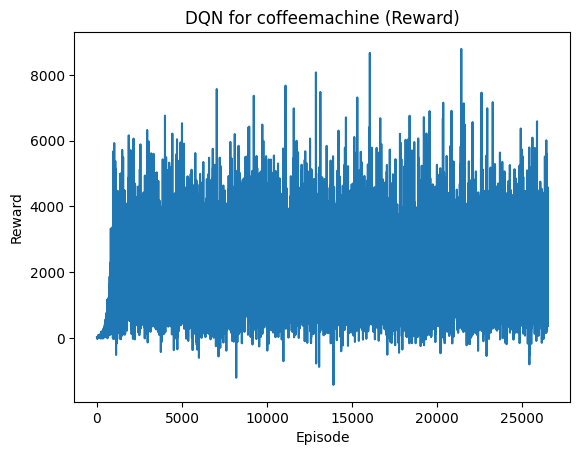

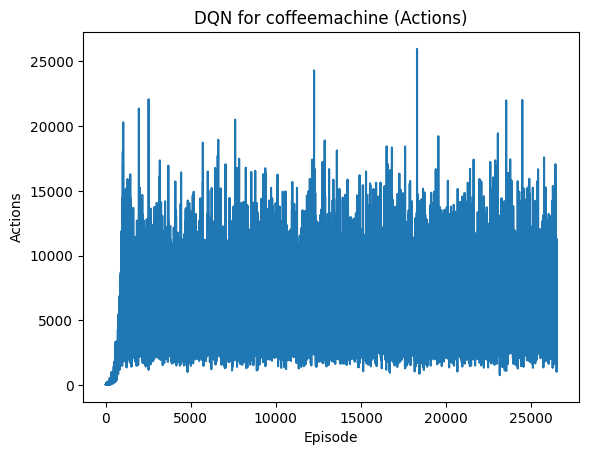

In [6]:
# Plotting the rewards per episode
import matplotlib.pyplot as plt
plt.plot(df["Reward"])
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN for coffeemachine (Reward)')
plt.show()

plt.plot(df["Steps"])
plt.xlabel('Episode')
plt.ylabel('Actions')
plt.title('DQN for coffeemachine (Actions)')
plt.show()